# Week 8 - Multivariate Analysis

## Please run the cells of the notebook as you get to them while reading

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from sklearn import decomposition
from sklearn import linear_model
from sklearn import metrics

# 1. Lesson: Multivariate graphs

In this lesson, we'll consider some multivariate plots: heatmaps and bubble plots.  We'll also consider principal component analysis and multiple regression.

### Heatmaps

In this plot, we use a heatmap to count the total traffic tickets given to citizens.  A heatmap requires the x and y axes to be categorical, while the color involves a third, numerical variable.  In this example, each row of the DataFrame represents a traffic ticket given to one person in a particular city and year.  The data are given as three columns (city, year, and ticket), so we must use a pivot_table to transform it into a two-dimensional grid.  The cmap is set to "Blues" in the first example, meaning that the heatmap uses only blue as its color.  However, we could also use a multicolor map like "viridis" in the second example.  I personally think "Blues" is easier to read - what do you think?  Here is a reference guide to the color maps:

https://matplotlib.org/stable/gallery/color/colormap_reference.html

In [2]:
np.random.seed(0)
num_samples = 100
city_series = np.random.choice(["New York", "Boston", "Atlanta", "Washington, D. C."], size = num_samples)
year_series = np.random.choice([2018, 2019, 2020], size = num_samples)
ticket_series = np.random.randint(50, 150, size = num_samples) # Traffic tickets can be from $50 to $150
df = pd.DataFrame({"city": city_series, "year": year_series, "ticket": ticket_series})
pivot = df.pivot_table(index = ["city"], columns = ["year"], values = "ticket", aggfunc = "sum")

In [3]:
df.iloc[0:5] # first five rows of a long DataFrame

,city,year,ticket
0,New York,2019,79
1,"Washington, D. C.",2020,71
2,Boston,2018,75
3,New York,2018,130
4,"Washington, D. C.",2020,110


In [4]:
pivot # 2 by 2 grid showing total ticket amounts

year,2018,2019,2020
city,,,
Atlanta,742,440,538
Boston,775,628,922
New York,1122,841,596
"Washington, D. C.",1258,451,1385


Text(0.5, 1.0, 'Total traffic tickets by city and year')

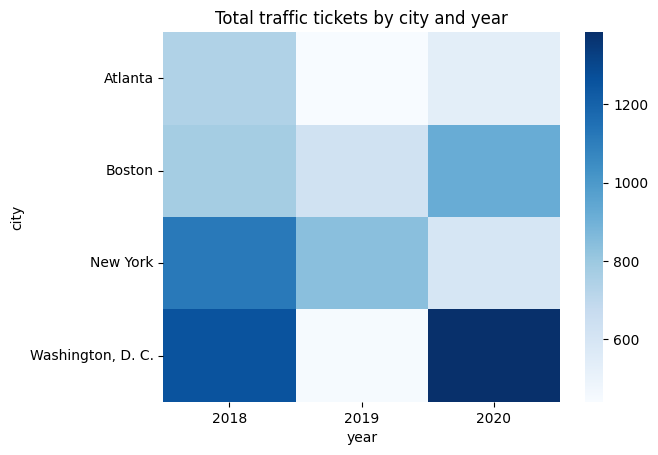

In [5]:
ax = sns.heatmap(pivot, cmap = "Blues")
ax.set_title("Total traffic tickets by city and year")

Text(0.5, 1.0, 'Average traffic ticket value by city and year')

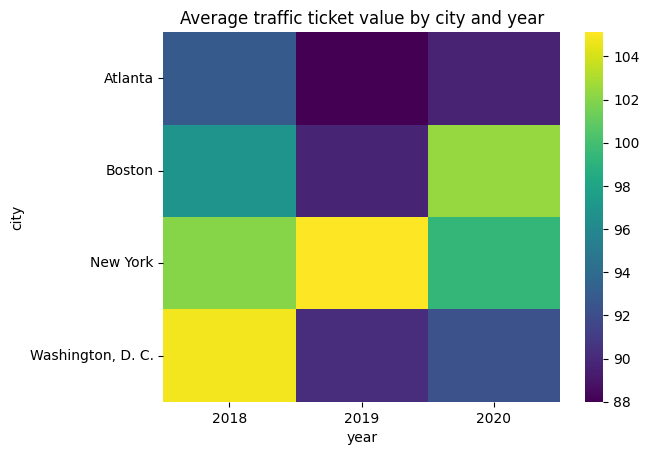

In [6]:
pivot2 = df.pivot_table(index = ["city"], columns = ["year"], values = "ticket", aggfunc = "mean") # note mean, not sum this time
ax2 = sns.heatmap(pivot2, cmap = "viridis") # do you think this is a better or worse scale than Blues?
ax2.set_title("Average traffic ticket value by city and year")

### Bubble plots

A bubble plot is just a scatter plot, but with the dot size representing a third variable.  Here, each data point shows a tree (I mean the kind of tree that is a plant and grows in the ground, not a decision tree), with its height, width of branches, and root depth.  The bubble size in the bubble plot represents the root depth, while the other variables are shown on the x and y axes.  From this plot, we can see that the root depth is strongly correlated with both the width of branches and the tree height.

Text(0, 0.5, 'width of branches')

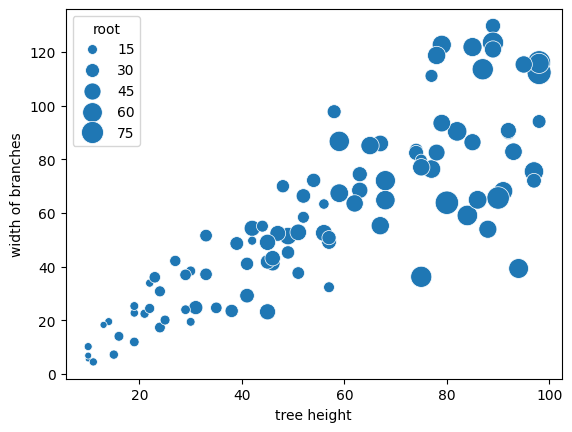

In [7]:
np.random.seed(0)
num_samples = 100
height_series = np.random.randint(10, 100, size = num_samples) # tree height
width_series = height_series * np.maximum(np.random.normal(scale = 0.3, loc = 1, size = num_samples), 0.25) # strongly related to height
root_series = height_series * np.maximum(np.random.normal(scale = 0.2, loc = 0.7, size = num_samples), 0.3) # strongly related to height
df2 = pd.DataFrame({'height': height_series, 'width': width_series, 'root': root_series})
minroot = root_series.min()
maxroot = root_series.max()
maxbubble = 300
ax = sns.scatterplot(data = df2, x = "height", y = "width", size = "root", sizes = (minroot / maxroot * maxbubble, maxbubble))
ax.set_xlabel("tree height")
ax.set_ylabel("width of branches")

### Principal Component Analysis

Principal Component Analysis can be thought of as a way to use one (or a few) linear combinations of the coordinates in order to explain all of the coordinates.  It is most useful when there are strong correlations between some or all of the coordinates.  Principal Component Analysis can show us which linear combinations are most (and least) useful for explaining the data.

With the trees data, the three values (height, width, and root) are highly correlated.  For this reason, Principal Component Analysis shows that most of the variance can be explained by a single value which is a linear combination of height, width, and root.  What this means is that if the first components_ vector in the code below (the "first principal component") is \[a, b, c\], for some specific numbers a, b, and c, then the value v = a * (height - mu_h) + b * (width - mu_w) + c * (root - mu_r), where the mu's are the means, is highly informative about the values of height, width, and root.  In this case, because height, width, and root are so highly correlated, we can almost assume that all of the data is located along an axis defined by the vector \[a, b, c\].  The point v * \[a, b, c\] + (mean vector) = (a * (height - mu_h) + b * (width - mu_w) + c * (root - mu_r)) * \[a, b, c\] + (mean vector) is therefore approximately equal to the data point (height, width, root) in question.  The mean vector is \[mu_h, mu_w, mu_r\].  Importantly, there is still variance unexplained by this one value - just knowing v * \[a, b, c\] does not tell you the height, width, and root with 100% accuracy.  If the second principal component is \[d, e, f\], then we could approximate the tree vector even more accurately as: (height, width, root) = (a * (height - mu_h) + b * (width - mu_w) + c * (root - mu_r)) * \[a, b, c\] + (d * (height - mu_h) + e * (width - mu_w) + f * (root - mu_r)) * \[d, e, f\] + (mean vector).

The printing of "components_", below, shows the first principal component \[a, b, c\].  If you draw a vector in the direction shown, you will be heading in the direction where the values height, width, and root change most rapidly.  A later computation shows all three principal component vectors.

**Optional exercise for the reader:** show that if all three principal components are included, then equality is exact.  This is going to be true simply because the principal components are orthonormal: the projections onto a complete set of orthonormal vectors always add up to the original vector.

(height, width, root) = (a * (height - mu_h) + b * (width - mu_w) + c * (root - mu_r)) * \[a, b, c\] + (d * (height - mu_h) + e * (width - mu_w) + f * (root - mu_r)) * \[d, e, f\] + (g * (height - mu_h) + h * (width - mu_w) + i * (root - mu_r)) * \[g, h, i\] + \[mu_h, mu_w, mu_r\].

For this proof, we must use the fact that the principal component vectors are orthonormal.  That is, any pair of them are orthogonal, even with a transpose (ad + be + cf = 0, ag + bh + ci = 0, dg + eh + fi = 0, ab + de + gh = 0, ac + df + gi = 0, bc + ef + hi = 0) and any one of them is a unit vector, even with a transpose (a^2 + b^c + c^2 = 1, d^2 + e^2 + f^2 = 1, g^2 + h^2 + i^2 = 1, a^2 + d^2 + g^2 = 1, b^2 + e^2 + h^2 = 1, c^2 + f^2 + i^2 = 1).  If you write out the equation above as a single vector, then apply the orthonormality rules, you should be able to prove equality.

In [8]:
pca = decomposition.PCA(n_components = 1)
pca.fit(df2)
print(f"The first principal component explains {pca.explained_variance_ratio_[0]} of the variance")
print(f"The components_ vector is [a, b, c] = {pca.components_}")
mu_h, mu_w, mu_r = df2.mean().values
print(f"(height, width, root) is approximately equal to ({pca.components_[0][0]:.2} * (height - {mu_h:.2}) + {pca.components_[0][1]:.2} * (width - {mu_w:.2}) + {pca.components_[0][2]:.2} * (root - {mu_r:.2})) * ({pca.components_[0][0]:.2}, {pca.components_[0][1]:.2}, {pca.components_[0][2]:.2}) + ({mu_h:.2}, {mu_w:.2}, {mu_r:.2})")
print("Examples: (estimating the the vector equals its projection onto the first principal component)")
df_example = df2.copy()
df_example["v"] = pca.components_[0][0] * (df2["height"] - mu_h) + pca.components_[0][1] * (df2["width"] - mu_w) + pca.components_[0][2] * (df2["root"] - mu_r)
df_example["height_est"] = df_example["v"] * pca.components_[0][0] + mu_h
df_example["width_est"] = df_example["v"] * pca.components_[0][1] + mu_w
df_example["root_est"] = df_example["v"] * pca.components_[0][2] + mu_r
print(df_example.iloc[0:5])
print("Means:")
print(f"mu_h = {mu_h:.3}", f"mu_w = {mu_w:.3}", f"mu_r = {mu_r:.3}")

The first principal component explains 0.8686108480944689 of the variance
The components_ vector is [a, b, c] = [[0.59031629 0.71908728 0.36666083]]
(height, width, root) is approximately equal to (0.59 * (height - 5.6e+01) + 0.72 * (width - 5.9e+01) + 0.37 * (root - 3.6e+01)) * (0.59, 0.72, 0.37) + (5.6e+01, 5.9e+01, 3.6e+01)
Examples: (estimating the the vector equals its projection onto the first principal component)
   height       width       root          v  height_est  width_est   root_est
0      54   72.139334  31.517932   6.287751   60.001762  63.563941  38.673095
1      57   49.169527  33.768693  -7.633330   51.783921  53.553468  33.568780
2      74   83.443733  28.770850  25.215680   71.175227  77.174773  45.613225
3      77   76.353866  53.061241  30.794730   74.468631  81.186597  47.658844
4      77  111.095365  26.006307  45.856916   83.360084  92.017624  53.181557
Means:
mu_h = 56.3 mu_w = 59.0 mu_r = 36.4


If we were to choose a second or third component to preserve, that values below show that each would explain a small, additional amount of the variance.  This means that with this particular dataset, we should likely do PCA using only one component and not two.  If the components' explained variances were closer in magnitude to each other, we might have to include two or even all three values to explain the data.

In [24]:
pca3 = decomposition.PCA(n_components = 3)
pca3.fit(df2)
print(pca3.explained_variance_ratio_)
print(pca3.components_)

[0.86861085 0.09414617 0.03724298]
[[ 0.59031629  0.71908728  0.36666083]
 [ 0.32633701 -0.62809127  0.70640322]
 [ 0.73826204 -0.29734633 -0.6054373 ]]


The principal component vectors shown are orthogonal to each other (their dot product is basically zero).  Here, we check that using the first two vectors.

In [10]:
print(np.array(pca3.components_[0]).dot(np.array(pca3.components_[1])))

-1.6653345369377348e-16


We can use the projection onto the first principal component as if it were a new feature.  For instance, we could plot a histogram of the data against the magnitude of the projection onto the first principal component.  In fact, for some purposes, this magnitude (which we have called v) might make a better feature for data analysis than either height, width, or root.  We must subtract off the mean before the dot product; the understanding is that this represents the component of the data relative to the mean.

<Axes: >

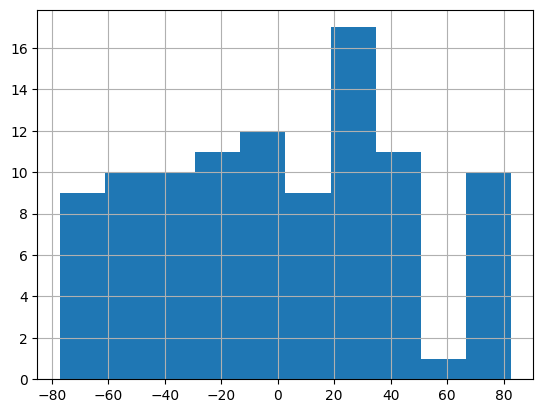

In [11]:
((df2 - df2.mean()).dot(np.array(pca.components_[0]))).hist()

In [12]:
# Showing that this is the same as the value we've called "v"
(df_example["v"] - (df2 - df2.mean()).dot(np.array(pca.components_[0]))).max()

0.0

### Linear Regression

Now let's run a linear regression model to predict the root from the height and width, as well as predicting the third principal component from the first and second.  Which is easier to predict?

### Predicting the root from the height and width

In [13]:
linreg = linear_model.LinearRegression()
linreg.fit(df2[['height', 'width']], df2['root'])
preds = linreg.predict(df2[['height', 'width']])
metrics.mean_squared_error(preds, df2['root']) # Mean squared error as a metric

138.22487356329611

In [14]:
np.corrcoef(preds, df2['root']) # Correlation coefficient as a metric

array([[1.        , 0.79468295],
       [0.79468295, 1.        ]])

### Predicting the third principal component from the first and second

In [15]:
first_principal_component_score = (df2 - df2.mean()).dot(np.array(pca3.components_[0]))
second_principal_component_score = (df2 - df2.mean()).dot(np.array(pca3.components_[1]))
third_principal_component_score = (df2 - df2.mean()).dot(np.array(pca3.components_[2]))

In [16]:
linreg_first = linear_model.LinearRegression()
pc_X = np.array([first_principal_component_score, second_principal_component_score]).T
linreg_first.fit(pc_X, third_principal_component_score)
preds = linreg_first.predict(pc_X)
metrics.mean_squared_error(preds, third_principal_component_score) # The mean squared error is a bit smaller here.

78.74928905273173

In [17]:
np.corrcoef(preds, third_principal_component_score) # More importantly, the correlation is basically zero

array([[1.00000000e+00, 1.55495941e-14],
       [1.55495941e-14, 1.00000000e+00]])

Here, we see that the projections of the first two principal components have no ability to predict the projection of the third, when measured by correlation.  This is a special property of principal components.  It is intended to ensure that the each component gives new information not present in the previous components.

The mean_squared_error is misleading - it makes it look like the error is less for the second computation than the first; but the correlation coefficient is giving more useful information here.  We cannot compare the mean squared error for two totally different computations, because mean squared error is highly dependent on the magnitudes of the values in question!

# 2. Weekly graph question

The tree data above can be graphed via either a pairplot or a bubble plot.  What are the advantages and disadvantages of each?

Text(0, 0.5, 'width of branches')

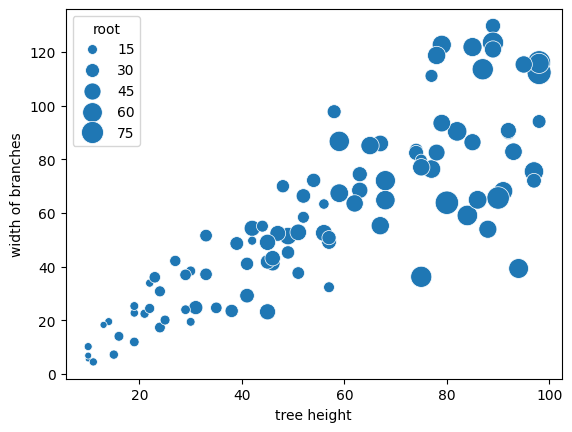

In [18]:
ax = sns.scatterplot(data = df2, x = "height", y = "width", size = "root", sizes = (minroot / maxroot * maxbubble, maxbubble))
ax.set_xlabel("tree height")
ax.set_ylabel("width of branches")

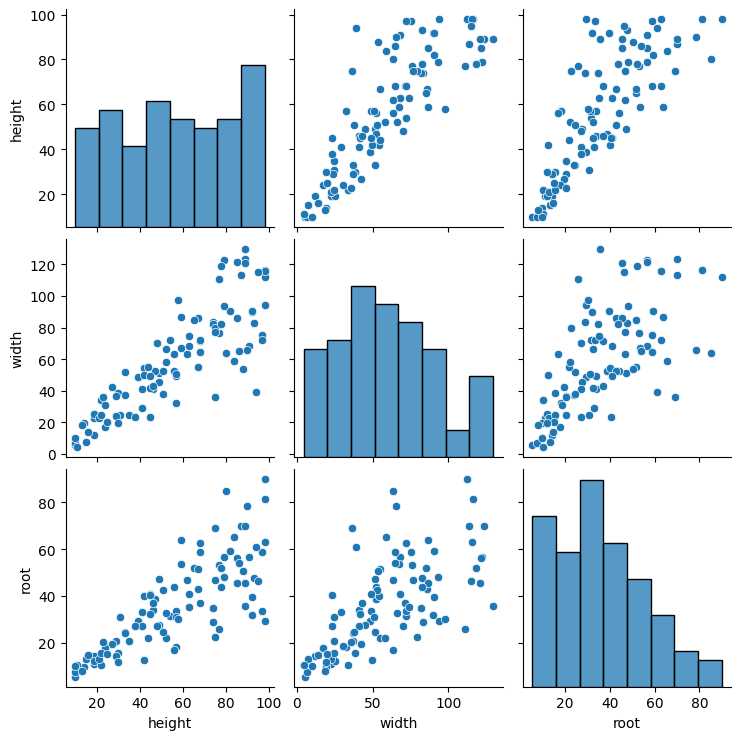

In [19]:
sns.pairplot(df2)

# 3. Homework - Grocery Store Correlation

In a particular state, the price of milk is highly correlated with the price of cheese.  Neither is correlated with the price of bread.

In [35]:
num_points = 1000
np.random.seed(0)
milk_series = np.maximum(np.random.normal(scale = 0.5, loc = 2.00, size = num_points), 1)
cheese_series = milk_series * np.maximum(np.random.normal(scale = 0.1, loc = 1.00, size = num_points), 0.5)
bread_series = np.maximum(np.random.normal(scale = 1.0, loc = 3.00, size = num_points), 1)
df3 = pd.DataFrame({"milk": milk_series, "cheese": cheese_series, "bread": bread_series})

### Heatmap

Draw a heatmap where the x-axis category is a discretized version of the milk price and the y-axis category is a discretized version of the cheese price.  That is, you can choose "low", "medium", and "high" for the milk price, or, if you prefer, you can choose 1, 2, 3, 4, and 5 for the five quintiles.  (The first quintile should include the bottom fifth of the data, the second quintile contains the next fifth, and so on).

Try Googling "how do I change numerical to categorical data" to get advice on this.

C:\Users\abcbb\AppData\Local\Temp\ipykernel_5844\3269057004.py:18: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df3_heatmap.pivot_table(


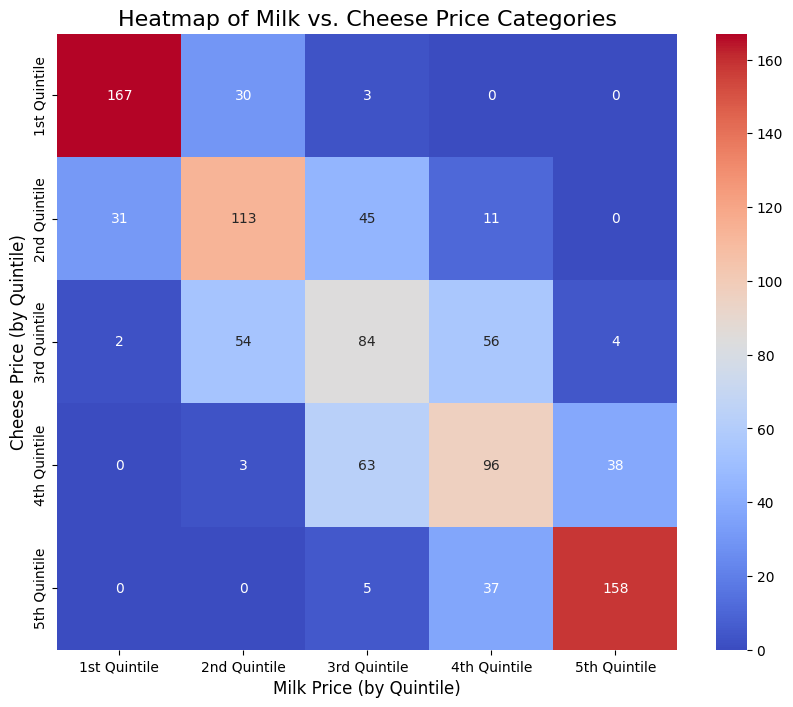

In [36]:
# --- Step 1: Discretize the numerical data into categorical bins ---
# We will use pd.qcut to divide the data into 5 quintiles (each containing 20% of the data).
quintile_labels = ['1st Quintile', '2nd Quintile', '3rd Quintile', '4th Quintile', '5th Quintile']
df3_heatmap = df3.copy()

# Create a new column for milk price quintiles.
df3_heatmap['milk_price_category'] = pd.qcut(df3_heatmap['milk'], q=5, labels=quintile_labels)
# Create a new column for cheese price quintiles.
df3_heatmap['cheese_price_category'] = pd.qcut(df3_heatmap['cheese'], q=5, labels=quintile_labels)


# --- Step 2: Create a pivot table for the heatmap ---
# A heatmap requires data in a 2D grid format. A pivot table is perfect for this.
# - index: will become the rows of the grid (y-axis).
# - columns: will become the columns of the grid (x-axis).
# - values: the column to aggregate. Here we just need to count occurrences.
# - aggfunc='count': this will count how many data points fall into each (milk, cheese) category pair.
heatmap_data = df3_heatmap.pivot_table(
    index='cheese_price_category',
    columns='milk_price_category',
    values='bread',  # We can use any column for counting.
    aggfunc='count'
)


# --- Step 3: Visualize the data with a heatmap ---
# Set the figure size for better readability.
plt.figure(figsize=(10, 8))

# Create the heatmap using seaborn.
# - annot=True: displays the count in each cell.
# - fmt='d': formats the numbers as integers.
# - cmap='YlGnBu': uses a Yellow-Green-Blue color map.
ax = sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='coolwarm')

# Set titles and labels for clarity.
ax.set_title('Heatmap of Milk vs. Cheese Price Categories', fontsize=16)
ax.set_xlabel('Milk Price (by Quintile)', fontsize=12)
ax.set_ylabel('Cheese Price (by Quintile)', fontsize=12)

# Show the plot.
plt.show()

This heatmap clearly shows that there is a strong positive correlation between milk prices and cheese prices. That is, when milk prices tend to be low, cheese prices tend to be low, and when milk prices are high, cheese prices tend to be high.

### Bubble plot

Try all three possible bubble plots: one where the size of the dot is determined by the milk price, one where it's the cheese price, and one where it's the bread price.  Which of these plots is / are the most informative and useful?

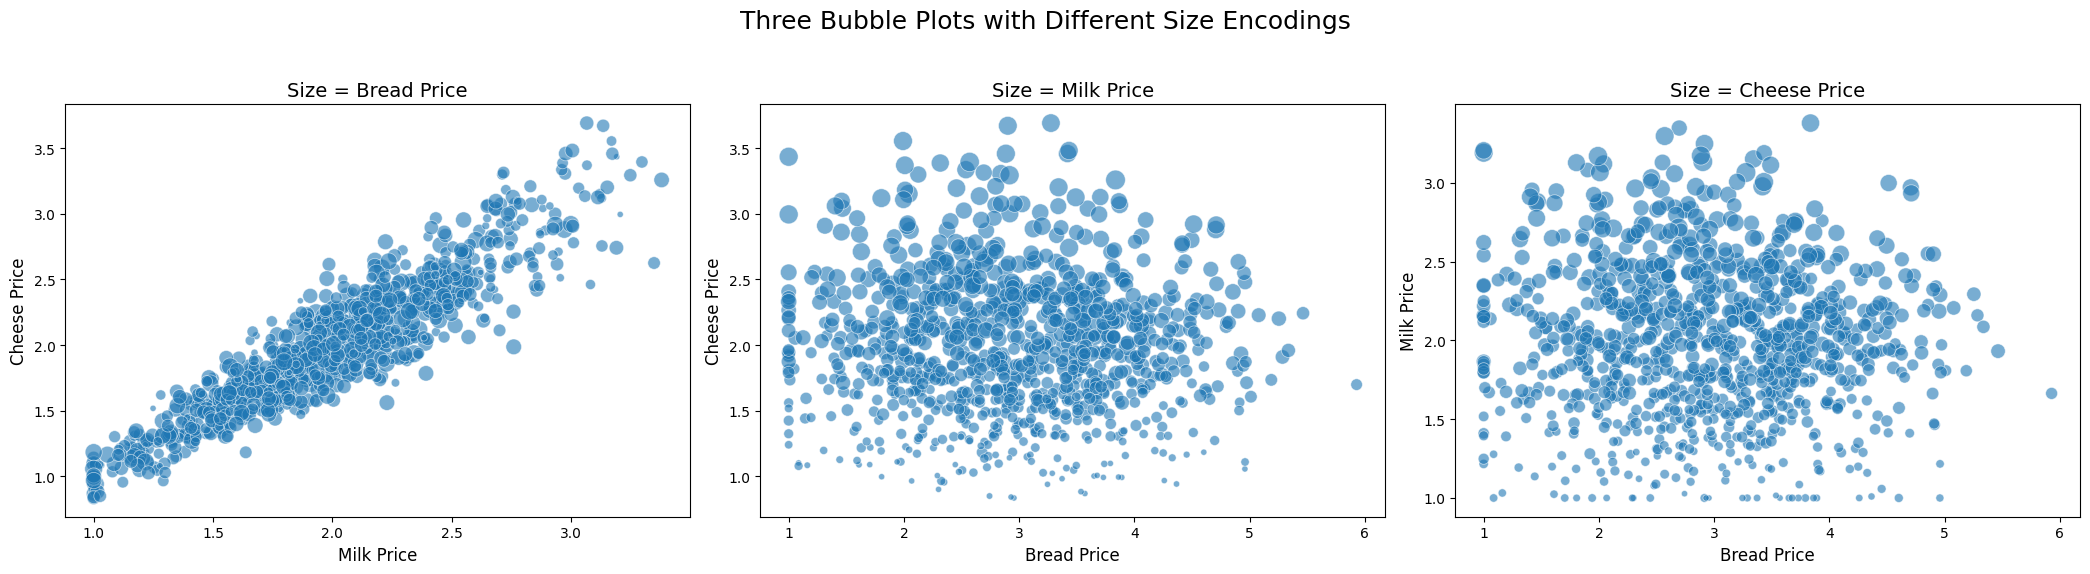

In [37]:
# --- Step 1: Create a figure with 3 subplots ---
# We create a 1x3 grid of plots to compare them side-by-side.
# figsize ensures the plots are large enough to see clearly.
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
fig.suptitle('Three Bubble Plots with Different Size Encodings', fontsize=18)
df3_bubble = df3.copy()


# --- Plot 1: Bread Price as Bubble Size ---
# This plot shows the relationship between milk and cheese on the axes.
sns.scatterplot(ax=axes[0], data=df3_bubble, x='milk', y='cheese', size='bread', 
                sizes=(20, 200), alpha=0.6, legend=False)
axes[0].set_title('Size = Bread Price', fontsize=14)
axes[0].set_xlabel('Milk Price', fontsize=12)
axes[0].set_ylabel('Cheese Price', fontsize=12)


# --- Plot 2: Milk Price as Bubble Size ---
# This plot shows the relationship between bread and cheese on the axes.
sns.scatterplot(ax=axes[1], data=df3_bubble, x='bread', y='cheese', size='milk', 
                sizes=(20, 200), alpha=0.6, legend=False)
axes[1].set_title('Size = Milk Price', fontsize=14)
axes[1].set_xlabel('Bread Price', fontsize=12)
axes[1].set_ylabel('Cheese Price', fontsize=12)


# --- Plot 3: Cheese Price as Bubble Size ---
# This plot shows the relationship between bread and milk on the axes.
sns.scatterplot(ax=axes[2], data=df3_bubble, x='bread', y='milk', size='cheese', 
                sizes=(20, 200), alpha=0.6, legend=False)
axes[2].set_title('Size = Cheese Price', fontsize=14)
axes[2].set_xlabel('Bread Price', fontsize=12)
axes[2].set_ylabel('Milk Price', fontsize=12)


# Adjust layout to prevent titles from overlapping and display the plots.
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Of the three charts, the first one is the most useful and informative. This is because it clearly shows the relationship between the two most correlated variables (milk price, cheese price) by placing them on the x-axis and y-axis, while effectively summarizing the relationship between the three variables in one visual by representing the third uncorrelated variable (bread price) as bubble size.

### Principal component analysis

Perform a principal component analysis of the data.  What are the first, second, and third component vectors?

Challenge question: explain why the three vectors point as they do.  (Could someone have guessed the order of the three vectors, even before running the analysis?)

In [38]:
# --- Step 1: Perform Principal Component Analysis ---
# Create a PCA object to find all 3 components.
pca_grocery = decomposition.PCA(n_components=3)

# Fit the PCA model to the grocery data.
pca_grocery.fit(df3)

PCA(n_components=3)

In [39]:
# --- Step 2: Print the results ---
# explained_variance_ratio_ shows the proportion of the dataset's variance
# that lies along each principal component.
variance_ratios = pca_grocery.explained_variance_ratio_

# components_ shows the principal component vectors. Each row is a component.
# The columns correspond to 'milk', 'cheese', and 'bread' in that order.
components = pca_grocery.components_

print("Explained Variance Ratios (for PC1, PC2, PC3):")
print(variance_ratios)
print("\nPrincipal Component Vectors:")
print("         [  milk,      cheese,    bread  ]")
print(f"PC1: {components[0]}")
print(f"PC2: {components[1]}")
print(f"PC3: {components[2]}")

Explained Variance Ratios (for PC1, PC2, PC3):
[0.63748768 0.34861425 0.01389806]

Principal Component Vectors:
         [  milk,      cheese,    bread  ]
PC1: [-0.03825586 -0.03809452  0.99854158]
PC2: [0.67873842 0.73239615 0.05394468]
PC3: [ 0.73338301 -0.67981224  0.00216223]


#### **1. Principal Component Vectors**

The first, second, and third component vectors are as follows:

* **PC1:** `[-0.038, -0.038, 0.998]`
* **PC2:** `[0.678, 0.732, 0.054]`
* **PC3:** `[0.733, -0.679, 0.002]`

#### **2. Explanation of the Vectors**

The direction of these vectors is determined by the variance in the data. PCA finds the directions (components) that capture the most variance in descending order.

* **PC1 (explains 63.7% of variance):** This vector is almost entirely aligned with the **bread price axis**. The coefficient for `bread` is nearly 1 (0.998), while the coefficients for `milk` and `cheese` are close to zero. This means the single largest source of variation in the dataset comes from the fluctuation of the bread price. This happens because the `bread` variable was created with a larger variance (`scale=1.0`) than the other variables.

* **PC2 (explains 34.9% of variance):** This vector represents the **strong positive correlation between milk and cheese prices**. The coefficients for `milk` (0.678) and `cheese` (0.732) are both large and positive. This captures the second-largest source of variance: the tendency for milk and cheese prices to increase and decrease together.

* **PC3 (explains 1.4% of variance):** This vector captures the small, remaining variance. It primarily represents the **minor difference between milk and cheese prices**. The coefficients for `milk` (0.733) and `cheese` (-0.679) are similar in magnitude but have opposite signs.

#### **3. Challenge Question: Could the order have been guessed beforehand?**

**Yes, the order of the components could have been predicted.**

This is possible by looking at how the data was created. We know two key things:

1.  **Correlation Structure:** `milk` and `cheese` are highly correlated, while `bread` is independent of the other two.
2.  **Variable Variance:** The data generation code uses `np.random.normal(scale=...)` to create the variables. The `scale` parameter is the standard deviation, and variance is the square of the standard deviation.
    * Variance of `bread` ≈ (scale 1.0)² = 1.0
    * Variance of `milk` ≈ (scale 0.5)² = 0.25

Since PCA prioritizes capturing the maximum variance, it was highly likely that the variable with the largest individual variance (`bread`) would be identified as the first principal component (PC1). The next largest source of variance would be the shared movement of the two correlated variables (`milk` and `cheese`), making that relationship PC2.

### Linear regression

Use linear regression to predict the milk price from the other two, the cheese price from the other two, and the bread price from the other two.  Which prediction(s) work the best, and why?

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# --- Model 1: Predicting Milk Price ---
# Features (input variables) are cheese and bread prices.
X_milk = df3[['cheese', 'bread']]
# Target (what we want to predict) is milk price.
y_milk = df3['milk']

# Create and fit the linear regression model.
lin_reg_milk = LinearRegression()
lin_reg_milk.fit(X_milk, y_milk)
# Make predictions.
milk_preds = lin_reg_milk.predict(X_milk)
# Calculate and print the R-squared score.
r2_milk = r2_score(y_milk, milk_preds)
print(f"R-squared for predicting Milk Price: {r2_milk:.4f}")


# --- Model 2: Predicting Cheese Price ---
# Features are milk and bread prices.
X_cheese = df3[['milk', 'bread']]
# Target is cheese price.
y_cheese = df3['cheese']

# Create, fit, and evaluate the model.
lin_reg_cheese = LinearRegression()
lin_reg_cheese.fit(X_cheese, y_cheese)
cheese_preds = lin_reg_cheese.predict(X_cheese)
r2_cheese = r2_score(y_cheese, cheese_preds)
print(f"R-squared for predicting Cheese Price: {r2_cheese:.4f}")


# --- Model 3: Predicting Bread Price ---
# Features are milk and cheese prices.
X_bread = df3[['milk', 'cheese']]
# Target is bread price.
y_bread = df3['bread']

# Create, fit, and evaluate the model.
lin_reg_bread = LinearRegression()
lin_reg_bread.fit(X_bread, y_bread)
bread_preds = lin_reg_bread.predict(X_bread)
r2_bread = r2_score(y_bread, bread_preds)
print(f"R-squared for predicting Bread Price: {r2_bread:.4f}")

R-squared for predicting Milk Price: 0.8522
R-squared for predicting Cheese Price: 0.8521
R-squared for predicting Bread Price: 0.0013


* **Milk and Cheese Price Prediction (R-squared ≈ 0.852):**
    * The R-squared for the model predicting milk price is 0.8522.
    * The R-squared for the model predicting cheese price is 0.8521.
    * These values are very close to 1.0, which indicates that both models have high predictive accuracy. This is because milk and cheese prices are strongly correlated. The model can effectively use the price of one to predict the price of the other.

* **Bread Price Prediction (R-squared ≈ 0.0013):**
    * The R-squared for the model predicting bread price is 0.0013, which is very close to 0.
    * This indicates that the model has almost no ability to predict the price of bread. This is because the price of bread is uncorrelated with the input variables (milk and cheese prices). Therefore, the model has no useful information to make an accurate prediction.

**In conclusion,** the performance of a predictive model is highly dependent on the correlation between variables. The highly correlated milk and cheese could predict each other well, while the uncorrelated bread was nearly impossible to predict.

# 4. Storytelling With Data plot



Reproduce any graph of your choice in p. 120-135 of the Storytelling With Data book as best you can.  ("Use color consistently" in chapter four up to "Create a clear visual hierarchy of information" in chapter five.)    You do not have to get the exact data values right, just the overall look and feel.

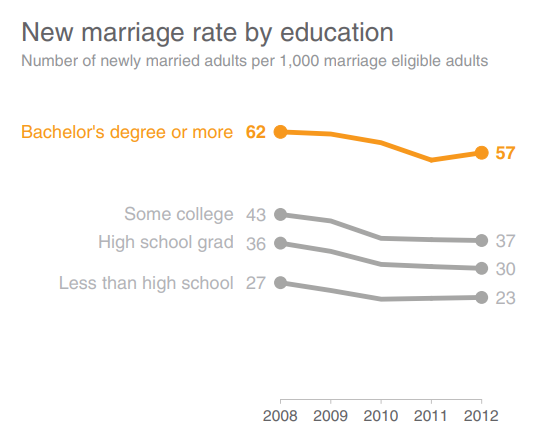

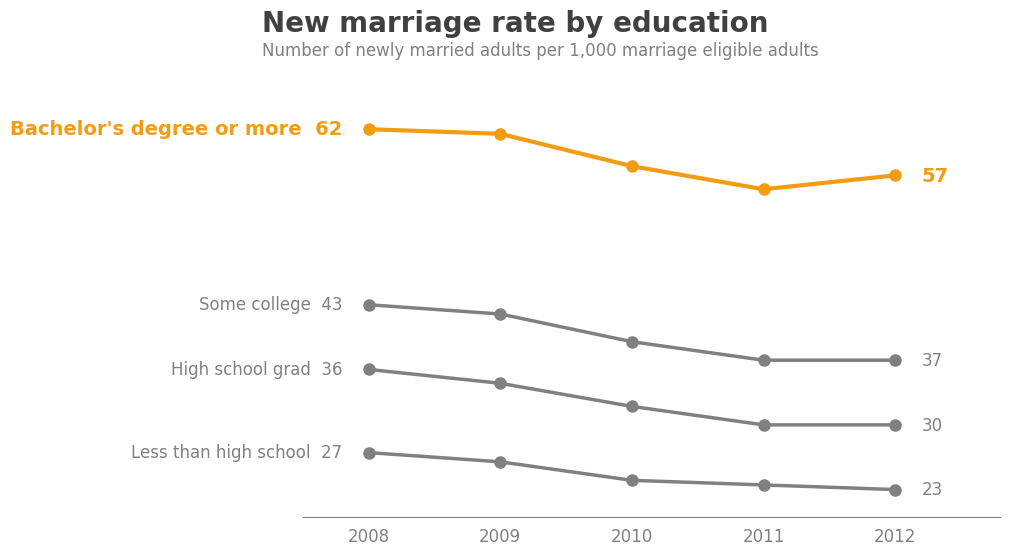

In [42]:
# --- 1. Prepare Data ---
# Data is estimated from the provided chart image.
years = [2008, 2009, 2010, 2011, 2012]
bachelors_rate = [62, 61.5, 58, 55.5, 57]
some_college_rate = [43, 42, 39, 37, 37]
high_school_rate = [36, 34.5, 32, 30, 30]
less_hs_rate = [27, 26, 24, 23.5, 23]

# --- 2. Define Colors and Styles ---
# Define specific colors to match the chart.
orange_color = '#f39c12'
gray_color = '#808080'
dark_gray_color = '#404040'

# --- 3. Create Plot ---
# Create a figure and axes object for plotting. Set the figure size.
fig, ax = plt.subplots(figsize=(9, 6))

# --- 4. Plot Data Lines ---
# Plot the highlighted "Bachelor's degree or more" line.
# 'clip_on=False' allows markers to be drawn outside the axes area.
ax.plot(years, bachelors_rate, color=orange_color, marker='o', markersize=8, linewidth=3, clip_on=False)
# Plot the other de-emphasized lines in gray.
ax.plot(years, some_college_rate, color=gray_color, marker='o', markersize=8, linewidth=2.5, clip_on=False)
ax.plot(years, high_school_rate, color=gray_color, marker='o', markersize=8, linewidth=2.5, clip_on=False)
ax.plot(years, less_hs_rate, color=gray_color, marker='o', markersize=8, linewidth=2.5, clip_on=False)

# --- 5. Add Titles and Text Annotations ---
# Add the main title and subtitle using figure coordinates for precise placement.
fig.text(0.08, 0.92, 'New marriage rate by education', fontsize=20, fontweight='bold', ha='left', color=dark_gray_color)
fig.text(0.08, 0.88, 'Number of newly married adults per 1,000 marriage eligible adults', fontsize=12, ha='left', color=gray_color)

# Add line labels on the left side (start points).
# 'ha='right'' aligns the text to the right of the specified coordinate.
ax.text(2007.8, bachelors_rate[0], f"Bachelor's degree or more  {bachelors_rate[0]}", color=orange_color, fontsize=14, fontweight='bold', ha='right', va='center')
ax.text(2007.8, some_college_rate[0], f'Some college  {some_college_rate[0]}', color=gray_color, fontsize=12, ha='right', va='center')
ax.text(2007.8, high_school_rate[0], f'High school grad  {high_school_rate[0]}', color=gray_color, fontsize=12, ha='right', va='center')
ax.text(2007.8, less_hs_rate[0], f'Less than high school  {less_hs_rate[0]}', color=gray_color, fontsize=12, ha='right', va='center')

# Add value labels on the right side (end points).
# 'ha='left'' aligns the text to the left of the specified coordinate.
ax.text(2012.2, bachelors_rate[-1], bachelors_rate[-1], color=orange_color, fontsize=14, fontweight='bold', ha='left', va='center')
ax.text(2012.2, some_college_rate[-1], some_college_rate[-1], color=gray_color, fontsize=12, ha='left', va='center')
ax.text(2012.2, high_school_rate[-1], high_school_rate[-1], color=gray_color, fontsize=12, ha='left', va='center')
ax.text(2012.2, less_hs_rate[-1], less_hs_rate[-1], color=gray_color, fontsize=12, ha='left', va='center')

# --- 6. Style the Axes ---
# Set axis limits to provide padding for labels.
ax.set_xlim(2007.5, 2012.8)
ax.set_ylim(20, 70)

# Set the x-axis ticks to show only the years.
ax.set_xticks(years)
ax.tick_params(axis='x', colors=gray_color, labelsize=12)

# Remove the top, right, and left spines (borders) for a cleaner look.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color(gray_color)

# Remove y-axis ticks and labels completely.
ax.set_yticks([])
ax.get_yaxis().set_visible(False)

# Remove the small tick marks on the x-axis, leaving only the labels and the line.
ax.tick_params(bottom=False)

# --- 7. Display the Plot ---
plt.show()